# An example of customising Pints plots

This example builds on [adaptive covariance MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mc.html) and [pairwise scatterplots](mcmc-pairwise-scatterplots.ipynb), and shows you how to plot the parameter distributions with examples of customising the plots.

## Setting up an MCMC routine

See the adaptive covariance MCMC example for details.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 50
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Perform sampling using MCMC, with a single chain
x0 = real_parameters * 1.1
mcmc = pints.MCMCController(log_posterior, 1, [x0])
mcmc.set_max_iterations(6000)
mcmc.set_log_to_screen(False)

## Plotting Pints' standard 1d histograms

We can now run the MCMC routine and plot the histograms of the inferred parameters.

In [2]:
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


In [3]:
# Select chain 0 and discard warm-up
chain = chains[0]
chain = chain[3000:]

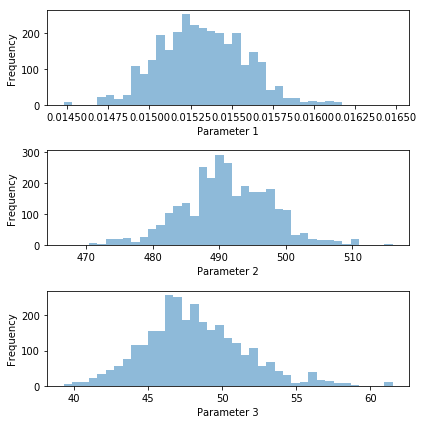

In [4]:
import pints.plot

# Plot the 1d histogram of each parameter
pints.plot.histogram([chain])
plt.show()

## Customise the plots

For example, here our [toy model](https://pints.readthedocs.io/en/latest/toy/logistic_model.html) is a logistic model of population growth
$$f(t) = \frac{k}{1 + (k/p_0 - 1)\exp(-rt)},$$
where $r$ is the growth rate, $k$ is the carrying capacity, and $p_0$ is the initial population.

1. We have model parameters $r$ and $k$, together with a noise parameter $\sigma$. Then we may want to name the labels to the name of parameters.
2. We can add lines for (i) the mean and (ii) the 95% credible interval.

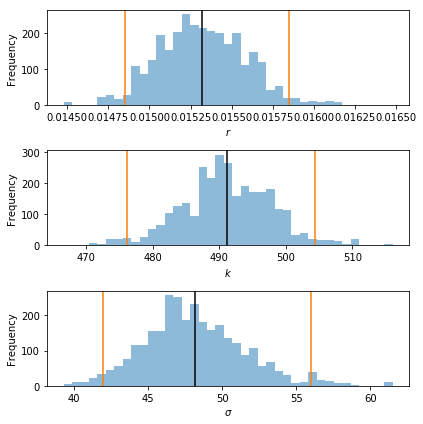

In [5]:
# Plot the 1d histogram of each parameter
fig, axes = pints.plot.histogram([chain])

# Customise the plots
parameter_names = [r'$r$', r'$k$', r'$\sigma$']
for i, ax in enumerate(axes):
    # (1) Add parameter name
    ax.set_xlabel(parameter_names[i])
    # (2i) Add mean
    ax.axvline(np.mean(chain[:, i]), color='k')
    # (2ii) Add 95% credible interval
    ax.axvline(np.percentile(chain[:, i], 2.5), color='C1')
    ax.axvline(np.percentile(chain[:, i], 97.5), color='C1')

plt.show()